In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import FastICA

In [2]:
"""
Load UCI ML Iris data
Return: data(shape = (150, 4)) and labels(shape = (150, 1)) in numpy array(rank 2)
"""
def load_data(classes):
    data = pd.read_csv('Iris.csv', index_col=0).as_matrix()
    features = data[:, :-1]
    labels = data[:, -1].reshape(-1, 1)
    for class_id in classes:
        labels[labels == class_id[0]] = class_id[1]
    return features.astype(np.float32), labels.astype(np.float32)

In [3]:
"""
Perform Data Shuffling
Return: shuffled features and labels
"""
def data_shuffling(features, labels):
    shuffle_array = np.random.permutation(features.shape[0])
    features = features[shuffle_array]
    labels = labels[shuffle_array]
    return features, labels

In [4]:
"""
Splitting the data into train and test set
Variable: ratio = percentage of data for train set
Return: train set and test set
"""
def data_split(features, labels, ratio=0.7):
    train_end_index = np.ceil(features.shape[0] * 0.7).astype(np.int32)
    train_features = features[:train_end_index]
    train_labels = labels[:train_end_index]
    test_features = features[train_end_index:]
    test_labels = labels[train_end_index:]
    return train_features, train_labels, test_features, test_labels

In [5]:
"""
Perform standardization for features
Return: standardized features, standard deviation, mean
"""
def standardization(features, exist_params=False, std=None, mean=None, colvar=True):
    features = features.T if not colvar else features
    if not exist_params:
        std = np.std(features, axis=0, keepdims=True)
        mean = np.mean(features, axis=0, keepdims=True)
    standard_features = (features - mean) / std
    return standard_features, std, mean

In [6]:
"""
Preparation of data
Return: train_features, train_labels, test_features, test_labels
"""
def data_preparation(features, labels):
    features, labels = data_shuffling(features, labels)
    train_features = np.empty((0, 4))
    train_labels = np.empty((0, 1))
    test_features = np.empty((0, 4))
    test_labels = np.empty((0, 1))
    for each_class in classes:
        features_class = features[np.squeeze(labels == float(each_class[1]))]
        labels_class = labels[np.squeeze(labels == float(each_class[1]))]
        a, b, c, d = data_split(features_class, labels_class)
        train_features = np.append(train_features, a, axis=0)
        train_labels = np.append(train_labels, b, axis=0)
        test_features = np.append(test_features, c, axis=0)
        test_labels = np.append(test_labels, d, axis=0)
    train_features, train_labels = data_shuffling(train_features, train_labels)
    test_features, test_labels = data_shuffling(test_features, test_labels)
    train_features, std, mean = standardization(train_features)
    test_features, _, _ = standardization(test_features, exist_params=True, std=std, mean=mean)
    return train_features, train_labels, test_features, test_labels

In [7]:
"""
Perform Independent Component Analysis
"""
def ica(features, colvar=True):
    features = features.T if not colvar else features
    ICA = FastICA(n_components=2)
    features_reduced = ICA.fit_transform(features)
    return features_reduced

In [8]:
"""
k-NN inferening 
Variable: k = k-nearest neightbour
Return: predictions to inference set
"""
def kNN_inference(train_features, train_labels, inf_features, k=3):
    
    #Properties#
    train_data_size = train_features.shape[0]
    train_features_size = train_features.shape[1]
    inf_data_size = inf_features.shape[0]
    
    #Define saver of predictions #
    predictions = np.empty((inf_features.shape[0], 1))
    
    #Compute the predictions for all in inference set#
    for i in range(inf_data_size):
        current_inf = np.tile(inf_features[i].reshape(1, -1), (train_data_size, 1))
        euclidean = np.linalg.norm(np.subtract(train_features, current_inf), axis=1)
        sort_index = np.argsort(euclidean)
        euclidean = euclidean[sort_index]
        k_labels = train_labels.reshape(-1)[sort_index][:k]
        pred_class, counts = np.unique(k_labels, return_counts=True)
        predict = pred_class[np.argmax(counts)]
        predictions[i] = predict
    return predictions

In [9]:
"""
Plot the scatter graphs
"""
def plot_scatter(features, labels):
    num_features = features.shape[1]
    for i in range(num_features - 1):
        for j in range(i + 1, num_features):
            plt.plot(features[np.squeeze(labels == float(0))][:, i], features[np.squeeze(labels == float(0))][:, j], 'rx', label='Iris-setosa')
            plt.plot(features[np.squeeze(labels == float(1))][:, i], features[np.squeeze(labels == float(1))][:, j], 'gx', label='Iris-versicolor')
            plt.plot(features[np.squeeze(labels == float(2))][:, i], features[np.squeeze(labels == float(2))][:, j], 'bx', label='Iris-virginica')
            plt.title('x{} - x{}'.format(i + 1, j + 1))
            plt.legend(loc='best')
            plt.show()

In [10]:
"""
Settings
"""
classes = [('Iris-setosa', 0), ('Iris-versicolor', 1), ('Iris-virginica', 2)]
cross_val_times = 10

Scatter Plots of Original Data: 


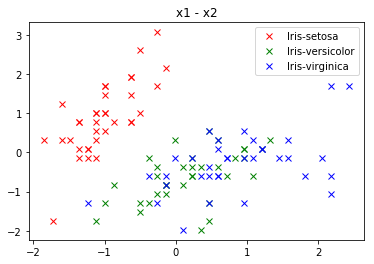

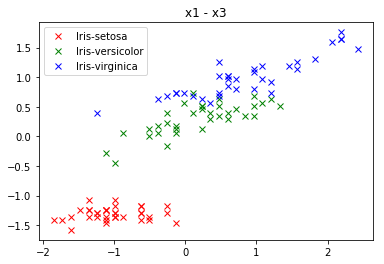

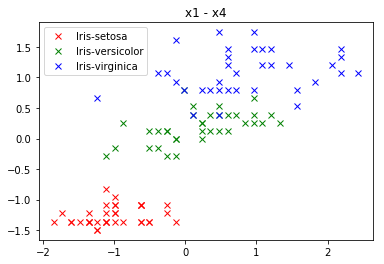

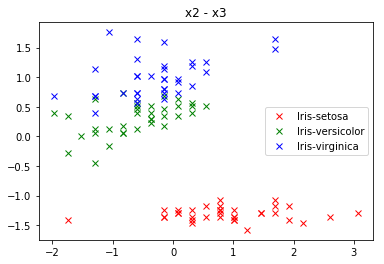

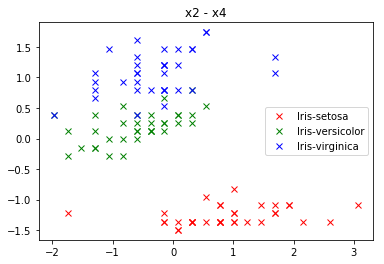

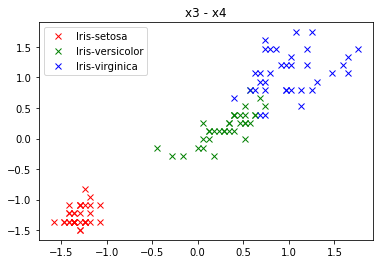

Scatter Plots of ICA-transformed Data: 


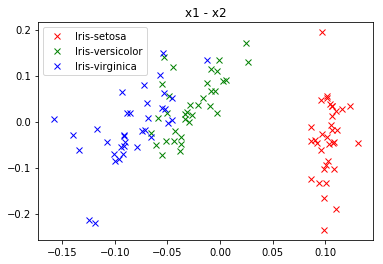

Average Accuracy (10 times): 0.9600000023841857


In [11]:
features, labels = load_data(classes)
avg_accuracy = 0.
for i in range(cross_val_times):
    train_features, train_labels, test_features, test_labels = data_preparation(features, labels)
    train_num = train_features.shape[0]
    test_num = test_features.shape[0]
    features_reduced = ica(np.append(train_features, test_features, axis=0))
    train_features_reduced = features_reduced[:train_num]
    test_features_reduced = features_reduced[train_num:train_num + test_num]
    predicts = kNN_inference(train_features, train_labels, test_features)
    avg_accuracy += np.mean((predicts == test_labels).astype(np.float32)) / cross_val_times
print('Scatter Plots of Original Data: ')
plot_scatter(train_features, train_labels)
print('Scatter Plots of ICA-transformed Data: ')
plot_scatter(train_features_reduced, train_labels)
print('Average Accuracy ({} times): {}'.format(cross_val_times, avg_accuracy))